<a class="anchor" id="0"></a>

# **COVID-19 Confirmed Cases in Canada: Stationary Data Testing**

**Author:** Stephen Prudente  
**Date:** April 1st, 2022

**Purpose:** The objective of this workbook is to test whether or not the subset of data used is stationary or not. If the data is stationary than ARIMA (Autoregressive Integreated Moving Average) will be used in the main analysis. If the data is not stationary, then SARIMA will be used which supports univariate time series data that contains a seasonal component.

**Dataset:** The dataset being used comes from the Canadian Government open data portal. A subset of variables have been chosen that have shown a strong correlation towards the number of COVID-19 cases to allow greater focus on the main subject. The variable 'numtoday' represents the number of confirmed positive COVID-19 cases in Canada.

**Variables:**
1. numtoday - Number of confirmed COVID-19 cases per day.
2. numconf - Cumulative total of confirmed COVID-19 cases.
3. numtotal - Total number including COVID-19 positive cases, deaths, etc.
4. numrecover - Cumulative total of recovered COVID-19 cases.
5. numtests - Cumulative total of COVID-19 tests completed.
6. numdeaths -  Cumulative total of COVID-19 related deaths.
7. ratetests - The rate at which COVID-19 tests are done per dau.

## Importing Libraries & Dataset
**Dataset will focus on solely rows that contain 'Canada'**
Additionally, the 'date' field will act as the index for the data subset with a time period selected for weekly aggregation.

In [1]:
#Importing packages
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Import the data
df = pd.read_csv("https://health-infobase.canada.ca/src/data/covidLive/covid19-download.csv")
df = df[df['prname'].str.contains('Canada')]
df['date'] = pd.to_datetime(df['date'])

# Set the date as index 
df = df.set_index('date')

df = df[['numconf','numtotal','numrecover','avgtotal_last7','numtotal_last7','numtotal_last14','numtests','numdeaths','ratetests','numactive','numtoday','numteststoday','numrecoveredtoday']]

# Selecting the proper time period for weekly aggreagation
df = df['2020-02-28':'2022-02-28'].resample('W').sum()
df.head()

,numconf,numtotal,numrecover,avgtotal_last7,numtotal_last7,numtotal_last14,numtests,numdeaths,ratetests,numactive,numtoday,numteststoday,numrecoveredtoday
date,,,,,,,,,,,,,
2020-03-01,39,39,0,3.43,24,31,1145,0,29.93,39,11,266,0
2020-03-08,248,248,0,27.57,193,228,7693,1,201.14,247,38,2064,0
2020-03-15,936,952,0,103.86,727,895,55571,6,1452.98,946,191,14658,0
2020-03-22,5866,6097,0,726.15,5083,5859,302770,70,7916.36,6027,1218,51373,0
2020-03-29,27324,28707,1510,3230.00,22610,27693,798746,201,20884.37,26996,4787,83865,522


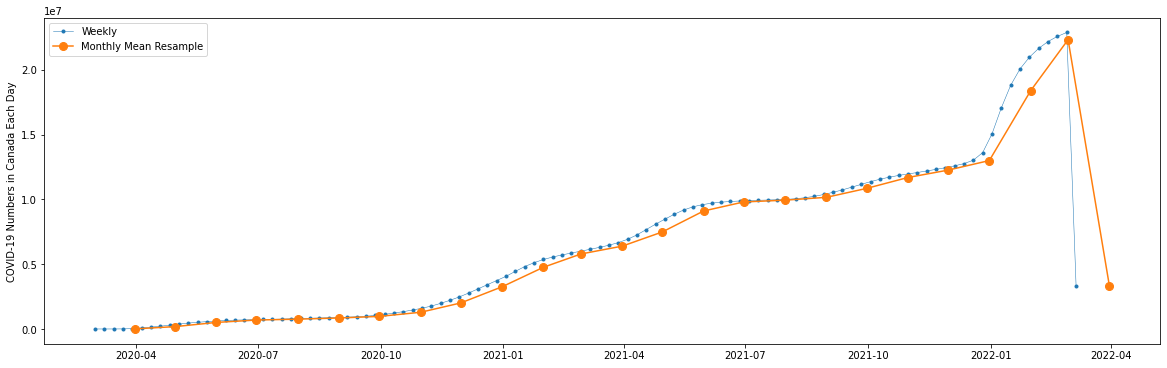

In [2]:
y = df['numconf']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('COVID-19 Numbers in Canada Each Day')
ax.legend();

In [3]:
#Graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

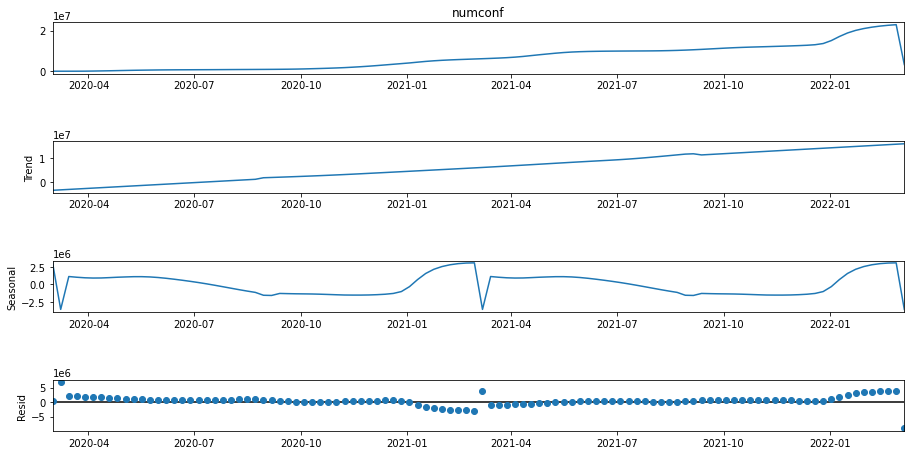

In [4]:
seasonal_decompose(y)

## Testing Stationarity

**Rolling Statistics**

In [5]:
def test_stationarity(timeseries, title):
    
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

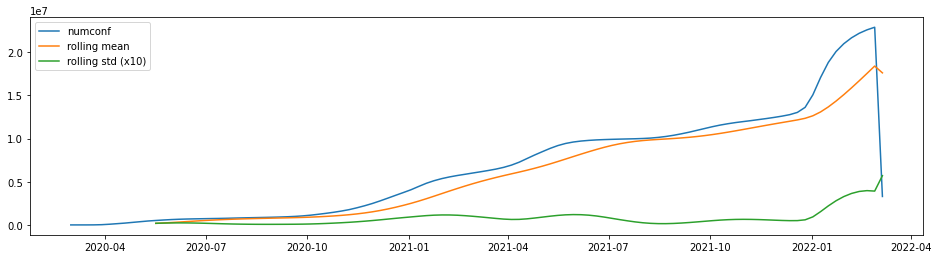

In [6]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'numconf')

**Augmented Dickey-Fuller Test**

In [7]:
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [8]:
ADF_test(y,'numconf')

 > Is the numconf stationary ?
Test statistic = -0.607
P-value = 0.869
Critical values :
	1%: -3.5019123847798657 - The data is not stationary with 99% confidence
	5%: -2.892815255482889 - The data is not stationary with 95% confidence
	10%: -2.583453861475781 - The data is not stationary with 90% confidence


**Detrending**

 > Is the de-trended data stationary ?
Test statistic = -0.849
P-value = 0.804
Critical values :
	1%: -3.510711795769895 - The data is not stationary with 99% confidence
	5%: -2.8966159448223734 - The data is not stationary with 95% confidence
	10%: -2.5854823866213152 - The data is not stationary with 90% confidence


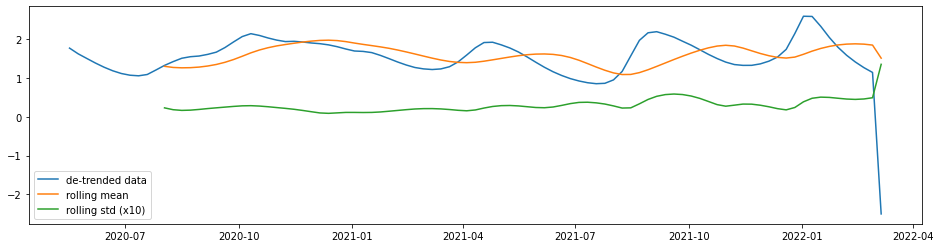

In [9]:
y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

This method removes the underlying seasonal or cyclical patterns in the time series. Since the sample dataset has a 12-month seasonality, I used a 12-lag difference:

**Differencing**

 > Is the 12 lag differenced data stationary ?
Test statistic = -2.112
P-value = 0.240
Critical values :
	1%: -3.512738056978279 - The data is not stationary with 99% confidence
	5%: -2.8974898650628984 - The data is not stationary with 95% confidence
	10%: -2.585948732897085 - The data is not stationary with 90% confidence


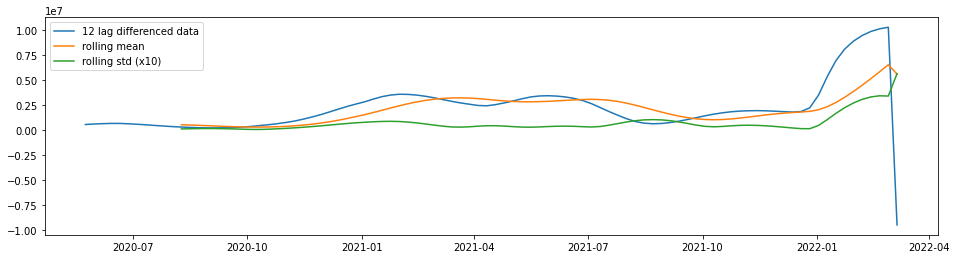

In [10]:
y_12lag =  y - y.shift(12)

test_stationarity(y_12lag,'12 lag differenced data')
ADF_test(y_12lag,'12 lag differenced data')

This method did not perform as well as the de-trending did, as indicated by the ADF test which is not stationary within 99 percent of the confidence interval.

Using the combination of the two methods, we see from both the visualization and the ADF test that the data is now stationary. This is the transformation we will use moving forward with our analysis.

**Detrending + Differencing**

 > Is the 12 lag differenced de-trended data stationary ?
Test statistic = 0.218
P-value = 0.973
Critical values :
	1%: -3.524624466842421 - The data is not stationary with 99% confidence
	5%: -2.9026070739026064 - The data is not stationary with 95% confidence
	10%: -2.5886785262345677 - The data is not stationary with 90% confidence


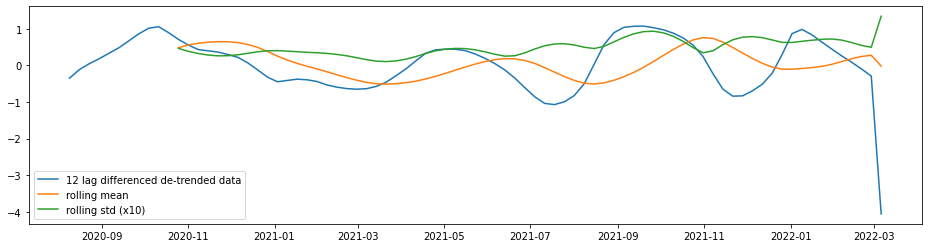

In [11]:
y_12lag_detrend =  y_detrend - y_detrend.shift(12)

test_stationarity(y_12lag_detrend,'12 lag differenced de-trended data')
ADF_test(y_12lag_detrend,'12 lag differenced de-trended data')

**Training Dataset**

In [12]:
y_to_train = y[:'2021-09-01']
y_to_val = y['2022-01-01':]
predict_date = len(y) - len(y[:'2022-03-02'])